### Bibliotecas necessárias


In [80]:
# Implementation of matplotlib function
import cv2
import matplotlib.pyplot as plt
import numpy as np  

### Abrir imagem

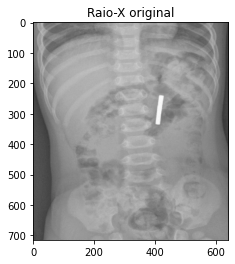

In [83]:
def loadImage(image: str):
    image = cv2.imread(image, cv2.IMREAD_COLOR) ## CHAVE ALTO CONSTRASTE 
    return image

loadedImage = loadImage("rx_4.png")
plt.imshow(loadedImage)
plt.title("Raio-X original")
plt.show()

### Conversão para escala de cinza

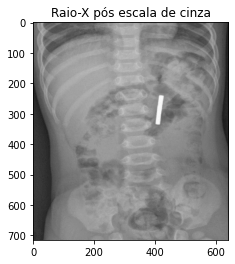

In [84]:

def toGrayScale(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #Converte para escala de cinza
    return grayScale

grayImage = toGrayScale(loadedImage)
plt.gray()
plt.imshow(grayImage)
plt.title("Raio-X pós escala de cinza")
plt.show()


### Ajuste de brilho e contraste
- Implementação de uma escala de ajuste para brilho e contraste, intervalo [-127, 127] semelhante ao GIMP

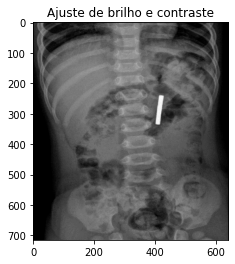

In [85]:
def gimpBrightContrastControl(image, brightness: float, contrast: float):

    brightness = brightness # brilho inicial 100
    contrast = contrast # contraste inicial 50
    shadow = 0
    highlight = 255 + brightness

    alpha_b = (highlight - shadow)/255
    gamma_b = shadow
    brightContrastProcImage = cv2.addWeighted(image, alpha_b, image, 0, gamma_b)
    f = 131*(contrast + 127)/(127*(131-contrast)) 
    alpha_c = f
    gamma_c = 127*(1-f)
    brightContrastProcImage = cv2.addWeighted(brightContrastProcImage, alpha_c, brightContrastProcImage, 0, gamma_c)

    return brightContrastProcImage

adjustedContrastBrightImg = gimpBrightContrastControl(grayImage, -100, 40) #-100, 50
plt.imshow(adjustedContrastBrightImg)
plt.title('Ajuste de brilho e contraste')
plt.show()

### Gradiente X - Sobel

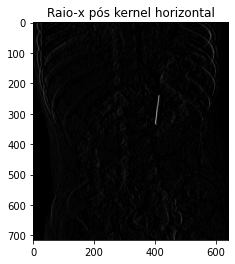

In [86]:
def applySobelGradientX(image, scale, delta, ddepth):   
    grad_x = cv2.Sobel(image, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    return grad_x

xSobelGradient = applySobelGradientX(adjustedContrastBrightImg, 1, 0, cv2.CV_16UC1)
plt.imshow(xSobelGradient)
plt.title("Raio-x pós kernel horizontal")
plt.show()

### Gradiente Y - Sobel

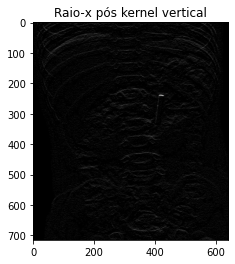

In [87]:

def applySobelGradientY(image, scale, delta, ddepth):   
    grad_y = cv2.Sobel(image, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    return grad_y

ySobelGradient = applySobelGradientY(adjustedContrastBrightImg, 1, 0, cv2.CV_16UC1)
plt.imshow(ySobelGradient)
plt.title("Raio-x pós kernel vertical")
plt.show()

### Conjugação dos resultados dos gradientes

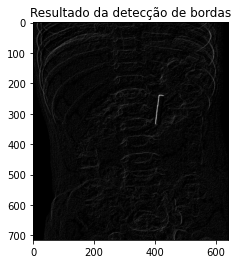

In [88]:
def mergeGradients(grad_x, grad_y):
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    imgSobel = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return imgSobel

imgSobel = mergeGradients(xSobelGradient, ySobelGradient)
plt.imshow(imgSobel)
plt.title("Resultado da detecção de bordas")
plt.show()

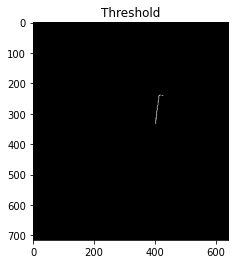

In [89]:
def applyThreshold(image, minThres: float, maxThres: float):
    ret, imgThreshold = cv2.threshold(image, minThres, maxThres, cv2.THRESH_BINARY) ##CANNY
    #print(ret)
    return imgThreshold

imageThreshold = applyThreshold(imgSobel, 121, 255) #121, 255
plt.imshow(imageThreshold)
plt.title("Threshold")
plt.show()

### Detecção de linhas

3


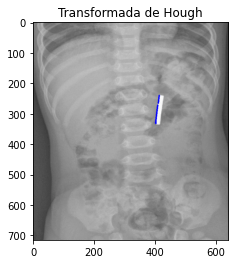

In [90]:
nroDetectedLines = 0

def applyHoughTransformLines(image, threshold, minLineLength, maxLineGap):
    lines = cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=threshold, minLineLength=minLineLength,maxLineGap = maxLineGap) ## COM THRESHOLD
    return lines

detectedLines = applyHoughTransformLines(imageThreshold, 30, 3, 1) #30, 3, 1

def drawLines(image, lines):
    try:
        if(lines.any != None):
            #print("Número de linhas detectadas: {}".format(len(lines)))

            for line in lines:
                x1, y1, x2, y2 = line[0]
                cv2.line(image, (x1, y1), (x2, y2), (0,0,255),4)
            return len(lines)
    except:
        #print("Nenhuma linha foi identificada nesta imagem")
        return 0

nroDetectedLines = drawLines(loadedImage, detectedLines)
print(nroDetectedLines)
plt.imshow(loadedImage)
plt.title("Transformada de Hough")
plt.show()

### Detecção de círculos

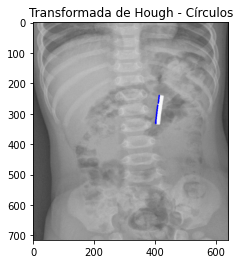

In [92]:
nroDetectedCircles = 0

def applyHoughTransformCircles(image, minRadius, maxRadius):
    rows = image.shape[0]
    circles = cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, rows / 8,
                                param1=200, param2=34,
                                minRadius=minRadius, maxRadius=maxRadius)
    return circles

detectedCircles = applyHoughTransformCircles(adjustedContrastBrightImg, 0, 70) #0,70

def drawCircles(image, circles):
    try:
        if (circles.any != None):
            circlesDetected = np.uint16(np.around(circles))
            for i in circlesDetected[0, :]:
                center = (i[0], i[1])
                # circle center
                cv2.circle(image, center, 1, (0, 100, 100), 3)
                # circle outline
                radius = i[2]
                cv2.circle(image, center, radius, (0, 0, 255), 3)
            return len(circles)
    except:
        return 0

nroDetectedCircles = drawCircles(loadedImage, detectedCircles)
plt.imshow(loadedImage)
plt.title("Transformada de Hough - Círculos")
plt.show()


In [94]:
def saveDetectedForeignBodies(imageName:str, image, nroCircles, nroLines):
    if(nroCircles !=0 or nroLines != 0):
        return cv2.imwrite('./Detected/DETECTED_{}'.format(imageName),image)
    else:
        return cv2.imwrite('./NotDetected/NOT_DETECTED_{}'.format(imageName),image)

saveDetectedForeignBodies("ImageTest.png",loadedImage, nroDetectedCircles, nroDetectedLines)   


True

### Processamento em lote

In [95]:
nroDetectedLines = 0
nroDetectedCircles = 0

imagens = ["rx_1.png", "rx_2.png", "rx_3.png", "rx_4.png", "rx_5.png",
           "rx_6.png", "rx_7.png", "rx_8.png", "rx_9.png", "rx_10.png", 
           "rx_11.png", "rx_12.png", "rx_13.png", "rx_14.png", "rx_15.png", 
           "rx_16.png", "rx_17.png", "rx_18.png"]

for i in range (0, len(imagens)):
    
    loadedImage = loadImage(imagens[i])
    grayImage = toGrayScale(loadedImage)
    adjustedContrastBrightImg = gimpBrightContrastControl(grayImage, -100, 40)
    xSobelGradient = applySobelGradientX(adjustedContrastBrightImg, 1, 0, cv2.CV_16UC1)
    ySobelGradient = applySobelGradientY(adjustedContrastBrightImg, 1, 0, cv2.CV_16UC1)
    imgSobel = mergeGradients(xSobelGradient, ySobelGradient)
    imageThreshold = applyThreshold(imgSobel, 121, 255)
    detectedLines = applyHoughTransformLines(imageThreshold, 30, 3, 1) #30, 3, 1
    nroDetectedLines = drawLines(loadedImage, detectedLines)
    detectedCircles = applyHoughTransformCircles(adjustedContrastBrightImg, 0, 70)
    nroDetectedCircles = drawCircles(loadedImage, detectedCircles)
    print("{} -> Círculos: {} | Linhas: {}".format(imagens[i], nroDetectedCircles, nroDetectedLines))
    saveDetectedForeignBodies(imagens[i], loadedImage, nroDetectedCircles, nroDetectedLines)
       
    

rx_1.png -> Círculos: 0 | Linhas: 3
rx_2.png -> Círculos: 1 | Linhas: 15
rx_3.png -> Círculos: 0 | Linhas: 23
rx_4.png -> Círculos: 0 | Linhas: 3
rx_5.png -> Círculos: 0 | Linhas: 4
rx_6.png -> Círculos: 0 | Linhas: 5
rx_7.png -> Círculos: 1 | Linhas: 0
rx_8.png -> Círculos: 0 | Linhas: 3
rx_9.png -> Círculos: 1 | Linhas: 0
rx_10.png -> Círculos: 0 | Linhas: 3
rx_11.png -> Círculos: 1 | Linhas: 0
rx_12.png -> Círculos: 0 | Linhas: 0
rx_13.png -> Círculos: 1 | Linhas: 10
rx_14.png -> Círculos: 1 | Linhas: 0
rx_15.png -> Círculos: 0 | Linhas: 0
rx_16.png -> Círculos: 1 | Linhas: 0
rx_17.png -> Círculos: 0 | Linhas: 6
rx_18.png -> Círculos: 0 | Linhas: 0
